<a href="https://colab.research.google.com/github/chetankhairnar05/Colab/blob/main/cattle_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!wget -O images.zip "https://www.kaggle.com/api/v1/datasets/download/lukex9442/indian-bovine-breeds"

# Step 2: Unzip the file
!unzip images.zip -d images

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Enable GPU acceleration and check available devices
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define paths
original_data_dir = '/content/images/Indian_bovine_breeds'
final_dataset_dir = '/content/final_dataset'

# Create directories
os.makedirs(final_dataset_dir, exist_ok=True)

# Get all breed folders
breed_folders = [f for f in os.listdir(original_data_dir)
                 if os.path.isdir(os.path.join(original_data_dir, f))]
print(f"Found {len(breed_folders)} breeds: {breed_folders}")

# Step 1: Create final dataset directory structure
train_dir = os.path.join(final_dataset_dir, 'train')
test_dir = os.path.join(final_dataset_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for breed in breed_folders:
    os.makedirs(os.path.join(train_dir, breed), exist_ok=True)
    os.makedirs(os.path.join(test_dir, breed), exist_ok=True)

# Step 2: GPU-accelerated image resizing and splitting
print("Resizing images to 256x256 and splitting into train/test...")

# Function to load, resize and save images using TensorFlow (GPU accelerated)
def process_and_save_images_gpu(source_path, target_path, image_names):
    """Process images using TensorFlow GPU operations"""
    for img_name in tqdm(image_names, desc=f"Processing {os.path.basename(target_path)}"):
        img_path = os.path.join(source_path, img_name)
        try:
            # Load image using TensorFlow (GPU accelerated)
            image = tf.io.read_file(img_path)
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, [256, 256])
            image = tf.cast(image, tf.uint8)

            # Save image
            encoded_image = tf.image.encode_jpeg(image)
            tf.io.write_file(os.path.join(target_path, img_name), encoded_image)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Process each breed
for breed in tqdm(breed_folders, desc="Processing breeds"):
    breed_path = os.path.join(original_data_dir, breed)
    train_breed_path = os.path.join(train_dir, breed)
    test_breed_path = os.path.join(test_dir, breed)

    # Get all images for this breed
    images = [f for f in os.listdir(breed_path)
              if os.path.isfile(os.path.join(breed_path, f)) and
              f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Split into train and test (80% train, 20% test)
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=SEED)

    # Process training images
    process_and_save_images_gpu(breed_path, train_breed_path, train_imgs)

    # Process test images
    process_and_save_images_gpu(breed_path, test_breed_path, test_imgs)

print("Image resizing and train/test split completed!")

# Step 3: Create augmented images with conservative transformations
print("Creating augmented images with conservative transformations...")

# Conservative augmentation parameters (preserve image quality)
datagen = ImageDataGenerator(
    rotation_range=15,           # Reduced rotation
    width_shift_range=0.1,       # Reduced shift
    height_shift_range=0.1,      # Reduced shift
    shear_range=0.1,             # Reduced shear
    zoom_range=0.1,              # Reduced zoom
    horizontal_flip=True,
    brightness_range=[0.9, 1.1], # Minimal brightness change
    fill_mode='reflect'          # Better edge handling
)

# Function to generate and save augmented images with progress tracking
def generate_conservative_augmentations(source_dir, num_augmented=10):
    """Generate conservative augmentations that preserve image quality"""
    total_images = 0
    for breed in breed_folders:
        breed_source_dir = os.path.join(source_dir, breed)
        image_files = [f for f in os.listdir(breed_source_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        total_images += len(image_files)

    progress_bar = tqdm(total=total_images * 10, desc="Generating augmentations")

    for breed in breed_folders:
        breed_source_dir = os.path.join(source_dir, breed)

        for img_name in os.listdir(breed_source_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(breed_source_dir, img_name)

                # Load the image using TensorFlow
                image = tf.io.read_file(img_path)
                image = tf.image.decode_image(image, channels=3)
                image = tf.expand_dims(image, axis=0)
                image = tf.cast(image, tf.float32)

                # Generate augmented images
                i = 0
                for batch in datagen.flow(image, batch_size=1,
                                         save_to_dir=breed_source_dir,
                                         save_prefix=f'aug_{os.path.splitext(img_name)[0]}',
                                         save_format='jpeg'):
                    i += 1
                    progress_bar.update(1)
                    if i >= num_augmented:
                        break
    progress_bar.close()

# Generate augmented images for training set
generate_conservative_augmentations(train_dir, num_augmented=10)

print("Augmentation completed! Augmented images added to training set.")

# Step 4: Verify the results
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return count

train_total = count_images(train_dir)
test_total = count_images(test_dir)
print(f"Final training images (original + augmented): {train_total}")
print(f"Test images (original only): {test_total}")

# Step 5: Create TensorFlow data generators with large batch size
print("Creating TensorFlow data generators with large batch size...")

# Data generator for training (with light augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,           # Very light augmentation for training
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.95, 1.05],
    validation_split=0.2
)

# Data generator for testing (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators with large batch size
batch_size = 1000  # Large batch size as requested
img_height, img_width = 256, 256

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Training classes: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Batch size: {batch_size}")

# Step 6: Display sample images from the final dataset
def display_sample_images(directory, title):
    """Display sample images with quality check"""
    for breed in breed_folders:
        breed_dir = os.path.join(directory, breed)
        if os.path.exists(breed_dir):
            image_files = [f for f in os.listdir(breed_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if image_files:
                break

    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize=16)

    # Display 5 sample images
    for i, img_file in enumerate(image_files[:5]):
        img_path = os.path.join(breed_dir, img_file)

        # Load with TensorFlow for consistency
        image = tf.io.read_file(img_path)
        image = tf.image.decode_image(image, channels=3)
        image = image.numpy()

        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.title(f"{breed}\n{img_file}" if i == 2 else f"{img_file}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display samples
display_sample_images(train_dir, "Sample Training Images (Original + Conservative Augmentation)")
display_sample_images(test_dir, "Sample Test Images (Original Only)")

print("All done! Your final dataset is ready at:", final_dataset_dir)
print("You can now use train_generator, validation_generator, and test_generator with your neural network!")

FINAL DATASET STATISTICS
Total training images: 51938 (4724 original + 47214 augmented)
Total test images: 1202 (1202 original + 0 augmented)
Total images in dataset: 53140
Train/Test ratio: 97.7% / 2.3%
Augmentation ratio: 10.0x (10 augmentations per image expected)

TRAINING SET BREAKDOWN:
------------------------------------------------------------
Breed                Total    Original   Augmented  Ratio   
------------------------------------------------------------
Alambadi             869      79         790        10.0x
Amritmahal           823      75         748        10.0x
Ayrshire             2057     187        1870       10.0x
Banni                946      86         860        10.0x
Bargur               814      74         740        10.0x
Bhadawari            747      68         679        10.0x
Brown_Swiss          1979     180        1799       10.0x
Dangi                714      65         649        10.0x
Deoni                869      79         790        10.0x
Gi

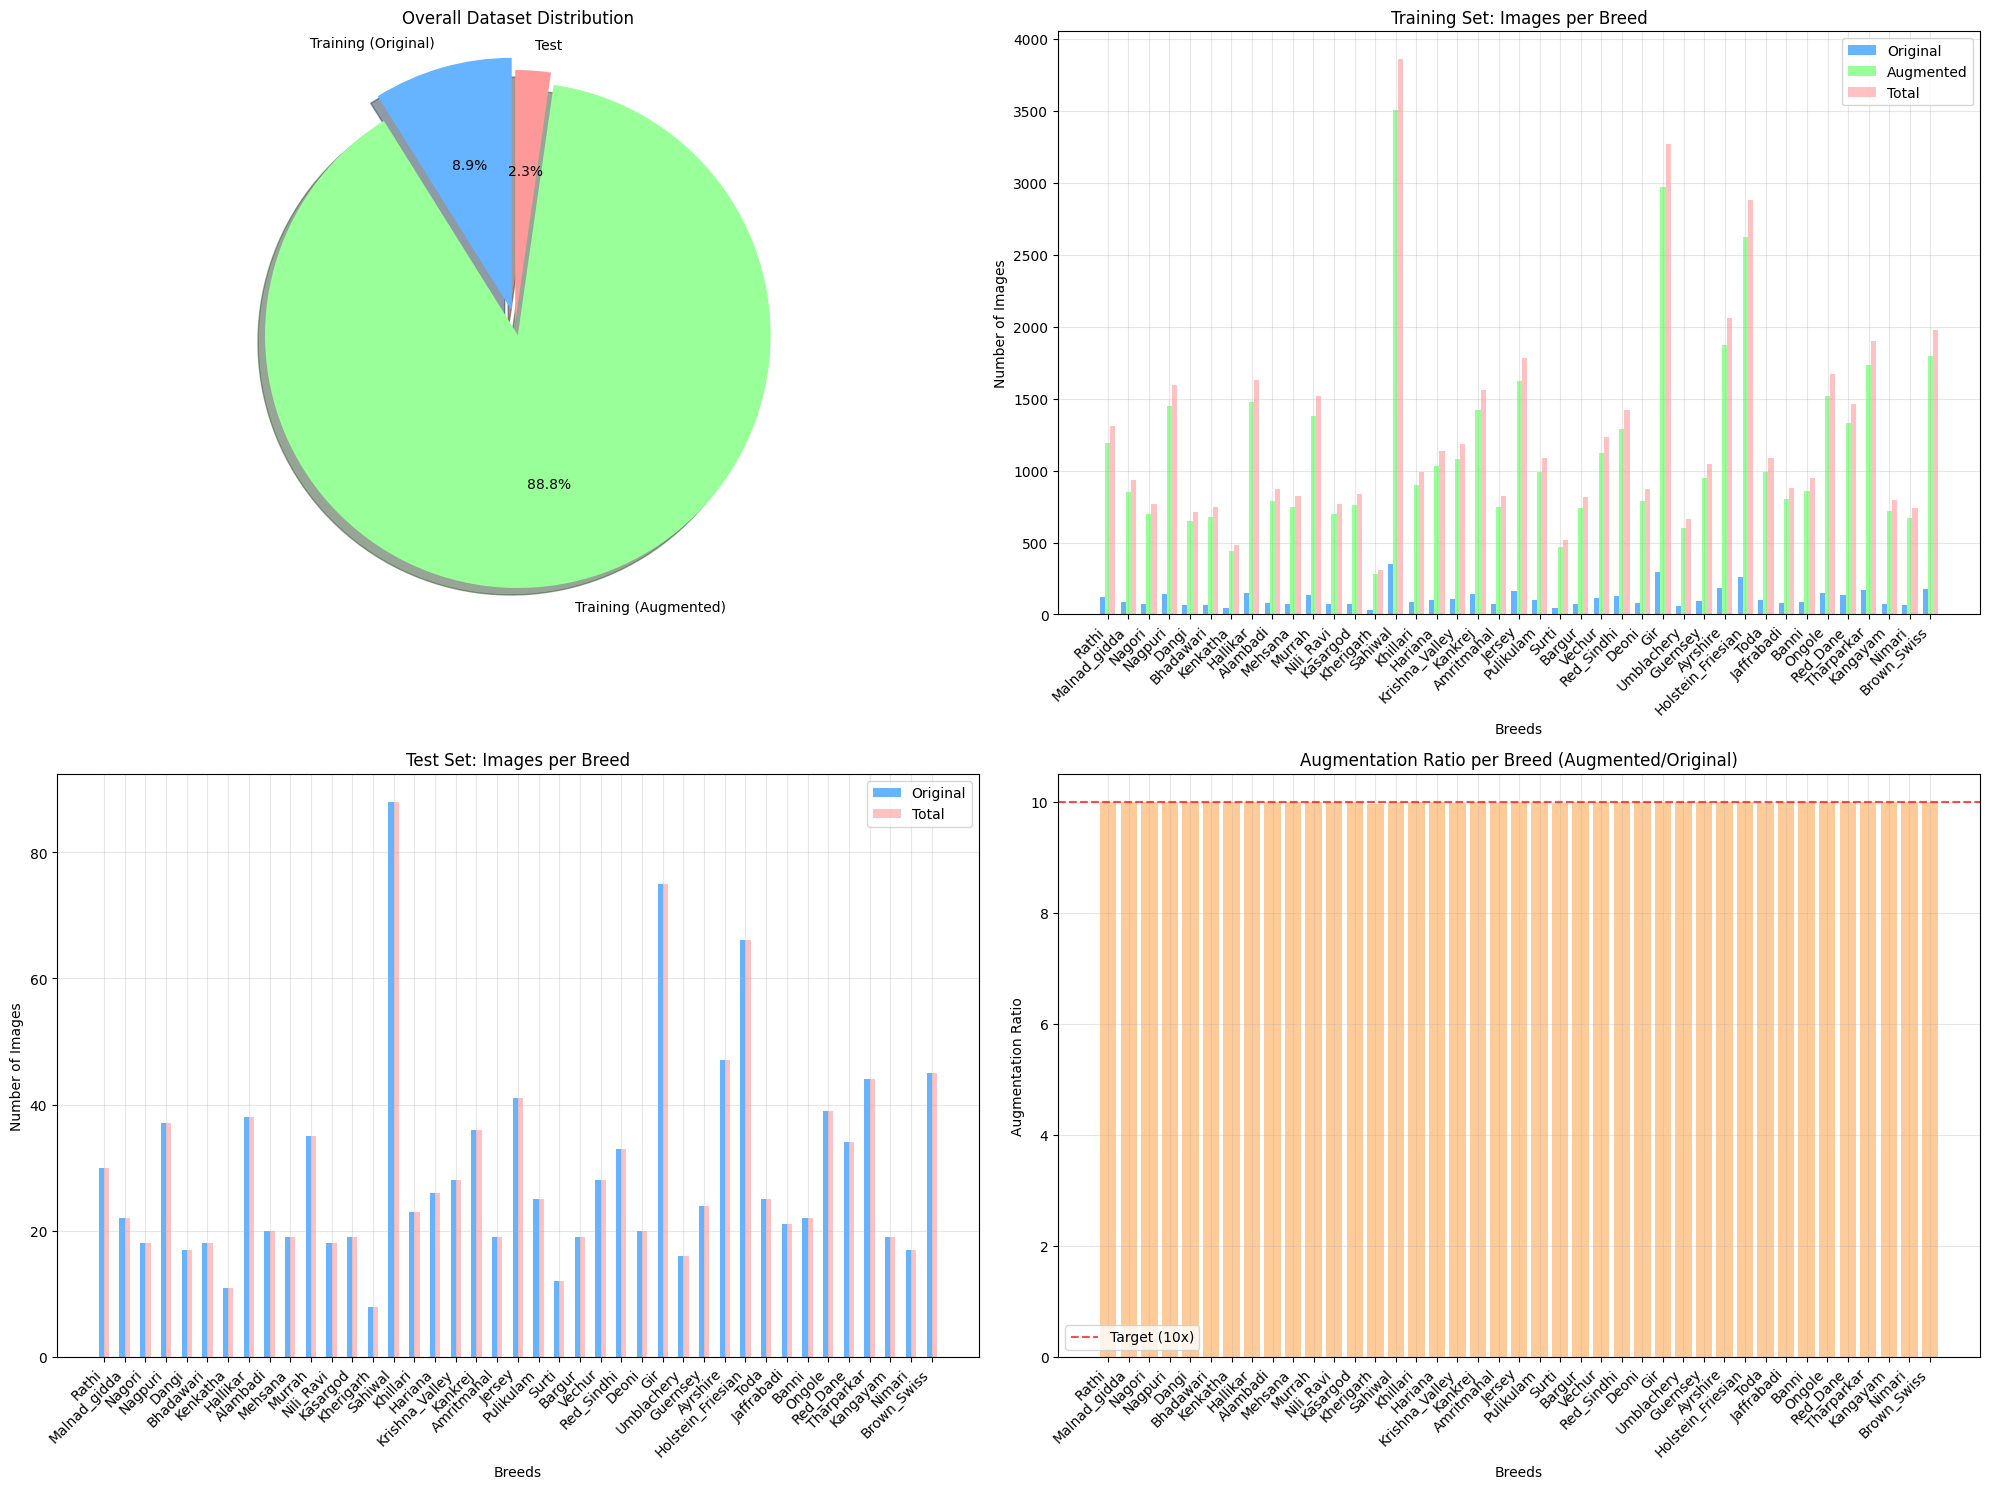


DETAILED STATISTICS
TRAINING SET:
  Total images: 51938
  Average per breed: 1266.8
  Standard deviation: 723.3
  Minimum: 307
  Maximum: 3858
  Original images: 4724
  Augmented images: 47214
  Average augmentation ratio: 10.0x

TEST SET:
  Total images: 1202
  Average per breed: 29.3
  Standard deviation: 16.4
  Minimum: 8
  Maximum: 88

Class imbalance ratio (max/min): 12.6
NOTE: Significant class imbalance detected.
Consider techniques like:


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Define paths
final_dataset_dir = '/content/final_dataset'
train_dir = os.path.join(final_dataset_dir, 'train')
test_dir = os.path.join(final_dataset_dir, 'test')

# Function to count images in each class with detailed breakdown
def count_images_detailed(directory):
    class_counts = {}
    total_images = 0
    original_count = 0
    augmented_count = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_original = 0
            class_augmented = 0

            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    if img_name.startswith('aug_'):
                        class_augmented += 1
                        augmented_count += 1
                    else:
                        class_original += 1
                        original_count += 1

            class_counts[class_name] = {
                'total': class_original + class_augmented,
                'original': class_original,
                'augmented': class_augmented
            }
            total_images += class_original + class_augmented

    return class_counts, total_images, original_count, augmented_count

# Count images in train and test sets
train_counts, train_total, train_original, train_augmented = count_images_detailed(train_dir)
test_counts, test_total, test_original, test_augmented = count_images_detailed(test_dir)

# Print detailed results
print("=" * 70)
print("FINAL DATASET STATISTICS")
print("=" * 70)
print(f"Total training images: {train_total} ({train_original} original + {train_augmented} augmented)")
print(f"Total test images: {test_total} ({test_original} original + {test_augmented} augmented)")
print(f"Total images in dataset: {train_total + test_total}")
print(f"Train/Test ratio: {train_total/(train_total+test_total)*100:.1f}% / {test_total/(train_total+test_total)*100:.1f}%")
print(f"Augmentation ratio: {train_augmented/train_original:.1f}x (10 augmentations per image expected)")
print()

# Print detailed breakdown for train set
print("TRAINING SET BREAKDOWN:")
print("-" * 60)
print(f"{'Breed':<20} {'Total':<8} {'Original':<10} {'Augmented':<10} {'Ratio':<8}")
print("-" * 60)
for breed, counts in sorted(train_counts.items()):
    ratio = counts['augmented'] / counts['original'] if counts['original'] > 0 else 0
    print(f"{breed:<20} {counts['total']:<8} {counts['original']:<10} {counts['augmented']:<10} {ratio:.1f}x")

print()
print("TEST SET BREAKDOWN:")
print("-" * 60)
print(f"{'Breed':<20} {'Total':<8} {'Original':<10} {'Augmented':<10}")
print("-" * 60)
for breed, counts in sorted(test_counts.items()):
    print(f"{breed:<20} {counts['total']:<8} {counts['original']:<10} {counts['augmented']:<10}")

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Pie chart for overall distribution
labels = ['Training (Original)', 'Training (Augmented)', 'Test']
sizes = [train_original, train_augmented, test_total]
colors = ['#66b3ff', '#99ff99', '#ff9999']
explode = (0.05, 0.05, 0)

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Overall Dataset Distribution')

# Bar chart for images per breed (training)
breeds = list(train_counts.keys())
train_totals = [train_counts[breed]['total'] for breed in breeds]
train_originals = [train_counts[breed]['original'] for breed in breeds]
train_augmenteds = [train_counts[breed]['augmented'] for breed in breeds]

x = np.arange(len(breeds))
width = 0.25

ax2.bar(x - width, train_originals, width, label='Original', color='#66b3ff')
ax2.bar(x, train_augmenteds, width, label='Augmented', color='#99ff99')
ax2.bar(x + width, train_totals, width, label='Total', color='#ff9999', alpha=0.6)

ax2.set_xlabel('Breeds')
ax2.set_ylabel('Number of Images')
ax2.set_title('Training Set: Images per Breed')
ax2.set_xticks(x)
ax2.set_xticklabels(breeds, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Bar chart for test set
test_totals = [test_counts[breed]['total'] for breed in breeds]
test_originals = [test_counts[breed]['original'] for breed in breeds]

ax3.bar(x - width/2, test_originals, width, label='Original', color='#66b3ff')
ax3.bar(x + width/2, test_totals, width, label='Total', color='#ff9999', alpha=0.6)

ax3.set_xlabel('Breeds')
ax3.set_ylabel('Number of Images')
ax3.set_title('Test Set: Images per Breed')
ax3.set_xticks(x)
ax3.set_xticklabels(breeds, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Augmentation ratio per breed
augmentation_ratios = []
for breed in breeds:
    if train_counts[breed]['original'] > 0:
        ratio = train_counts[breed]['augmented'] / train_counts[breed]['original']
        augmentation_ratios.append(ratio)
    else:
        augmentation_ratios.append(0)

ax4.bar(x, augmentation_ratios, color='#ffcc99')
ax4.set_xlabel('Breeds')
ax4.set_ylabel('Augmentation Ratio')
ax4.set_title('Augmentation Ratio per Breed (Augmented/Original)')
ax4.set_xticks(x)
ax4.set_xticklabels(breeds, rotation=45, ha='right')
ax4.axhline(y=10, color='r', linestyle='--', alpha=0.7, label='Target (10x)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
print("\n" + "=" * 70)
print("DETAILED STATISTICS")
print("=" * 70)

# Training set statistics
train_totals_list = [counts['total'] for counts in train_counts.values()]
train_originals_list = [counts['original'] for counts in train_counts.values()]
train_augmenteds_list = [counts['augmented'] for counts in train_counts.values()]

print("TRAINING SET:")
print(f"  Total images: {train_total}")
print(f"  Average per breed: {np.mean(train_totals_list):.1f}")
print(f"  Standard deviation: {np.std(train_totals_list):.1f}")
print(f"  Minimum: {min(train_totals_list)}")
print(f"  Maximum: {max(train_totals_list)}")
print(f"  Original images: {train_original}")
print(f"  Augmented images: {train_augmented}")
print(f"  Average augmentation ratio: {np.mean([a/o if o > 0 else 0 for a, o in zip(train_augmenteds_list, train_originals_list)]):.1f}x")

print("\nTEST SET:")
print(f"  Total images: {test_total}")
print(f"  Average per breed: {np.mean(list(test_counts[breed]['total'] for breed in breeds)):.1f}")
print(f"  Standard deviation: {np.std(list(test_counts[breed]['total'] for breed in breeds)):.1f}")
print(f"  Minimum: {min(list(test_counts[breed]['total'] for breed in breeds))}")
print(f"  Maximum: {max(list(test_counts[breed]['total'] for breed in breeds))}")

# Check for class imbalance
imbalance_ratio = max(train_totals_list) / min(train_totals_list) if min(train_totals_list) > 0 else float('inf')
print(f"\nClass imbalance ratio (max/min): {imbalance_ratio:.1f}")

if imbalance_ratio > 3:
    print("NOTE: Significant class imbalance detected.")
    print("Consider techniques like:")

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define constants
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 32  # Reduced from 1000 to avoid memory issues
NUM_CLASSES = len(breed_folders)  # Should be 41 based on your statistics

# Data augmentation specifically for cattle images
def create_cattle_augmentation():
    return tf.keras.Sequential([
        layers.RandomRotation(0.1),  # Limited rotation
        layers.RandomZoom(0.1),      # Limited zoom
        layers.RandomContrast(0.1),  # Minimal contrast changes
        layers.RandomTranslation(0.05, 0.05),  # Small translations
    ])

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Calculate class weights to handle imbalance
class_totals = [train_counts[breed]['total'] for breed in breed_folders]
class_weights = {}
for i, breed in enumerate(breed_folders):
    # Inverse frequency weighting - gives more weight to minority classes
    class_weights[i] = (1 / class_totals[i]) * (sum(class_totals) / NUM_CLASSES)

print(f"Number of classes: {NUM_CLASSES}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Build a specialized cattle-focused CNN architecture
def build_cattle_cnn(input_shape=(256, 256, 3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        # Initial convolutional layers with attention to cattle features
        layers.Conv2D(32, (7, 7), activation='selu', input_shape=input_shape,
                     kernel_regularizer=tf.keras.regularizers.l2(0.001),
                     kernel_initializer='lecun_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second block - focus on texture patterns (coat patterns)
        layers.Conv2D(64, (5, 5), activation='selu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001),
                     kernel_initializer='lecun_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third block - focus on shape features (horns, body shape)
        layers.Conv2D(128, (3, 3), activation='selu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001),
                     kernel_initializer='lecun_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Fourth block - detailed feature extraction
        layers.Conv2D(256, (3, 3), activation='selu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001),
                     kernel_initializer='lecun_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Fifth block - high-level feature extraction
        layers.Conv2D(512, (3, 3), activation='selu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001),
                     kernel_initializer='lecun_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Sixth block - additional feature extraction
        layers.Conv2D(512, (3, 3), activation='selu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001),
                     kernel_initializer='lecun_normal'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),  # Better for handling varying cattle sizes

        # Regularization to prevent overfitting
        layers.Dropout(0.2),

        # Final classification layers
        layers.Dense(512, activation='selu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001),
                    kernel_initializer='lecun_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation='selu',
                    kernel_initializer='lecun_normal'),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Alternative: Use transfer learning with fine-tuning
def build_transfer_learning_model(input_shape=(256, 256, 3), num_classes=NUM_CLASSES):
    # Use EfficientNetB0 as base (good balance between performance and size)
    base_model = applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze initial layers, unfreeze later ones for fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Choose which model to use
# model = build_cattle_cnn()  # Custom architecture
model = build_transfer_learning_model()  # Transfer learning approach

# Compile the model with appropriate settings for imbalanced data
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_cattle_model.h5', monitor='val_accuracy',
                   save_best_only=True, mode='max')
]

# Display model architecture
model.summary()

# Train the model
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,  # Important for imbalanced data
    verbose=1
)

# Evaluate the model
print("Evaluating model...")
test_results = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")

# Plot training history
def plot_training_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    # Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    # Precision
    ax3.plot(history.history['precision'], label='Training Precision')
    ax3.plot(history.history['val_precision'], label='Validation Precision')
    ax3.set_title('Model Precision')
    ax3.set_ylabel('Precision')
    ax3.set_xlabel('Epoch')
    ax3.legend()

    # AUC
    ax4.plot(history.history['auc'], label='Training AUC')
    ax4.plot(history.history['val_auc'], label='Validation AUC')
    ax4.set_title('Model AUC')
    ax4.set_ylabel('AUC')
    ax4.set_xlabel('Epoch')
    ax4.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Generate predictions and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Generating predictions and evaluation metrics...")
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
                          target_names=breed_folders))

# Confusion matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=breed_folders,
           yticklabels=breed_folders)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save the final model
model.save('indian_bovine_breed_classifier.h5')
print("Model saved as 'indian_bovine_breed_classifier.h5'")

Found 41567 images belonging to 41 classes.
Found 10371 images belonging to 41 classes.
Found 1202 images belonging to 41 classes.
Number of classes: 41
Training samples: 41567
Validation samples: 10371
Test samples: 1202
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389,068 (16.74 MB)

 Trainable params: 4,179,333 (15.94 MB)

 Non-trainable params: 209,735 (819.28 KB)

Starting training...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.0712 - auc: 0.5801 - loss: 5.5551 - precision: 0.2414 - recall: 0.0245

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 254s 149ms/step - accuracy: 0.0713 - auc: 0.5801 - loss: 5.5547 - precision: 0.2414 - recall: 0.0245 - val_accuracy: 0.1236 - val_auc: 0.7116 - val_loss: 3.6507 - val_precision: 0.2687 - val_recall: 0.0510 - learning_rate: 1.0000e-04
Epoch 2/50
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1580 - auc: 0.7595 - loss: 4.0652 - precision: 0.3892 - recall: 0.0590

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 141s 109ms/step - accuracy: 0.1580 - auc: 0.7595 - loss: 4.0650 - precision: 0.3893 - recall: 0.0590 - val_accuracy: 0.2227 - val_auc: 0.8331 - val_loss: 2.9098 - val_precision: 0.5311 - val_recall: 0.0808 - learning_rate: 1.0000e-04
Epoch 3/50
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 137s 106ms/step - accuracy: 0.2351 - auc: 0.8306 - loss: 3.4043 - precision: 0.4892 - recall: 0.1018 - val_accuracy: 0.1613 - val_auc: 0.7511 - val_loss: 3.8447 - val_precision: 0.2262 - val_recall: 0.0970 - learning_rate: 1.0000e-04
Epoch 4/50
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 139s 107ms/step - accuracy: 0.3208 - auc: 0.8831 - loss: 2.7989 - precision: 0.6031 - recall: 0.1684 - val_accuracy: 0.2207 - val_auc: 0.8257 - val_loss: 3.0683 - val_precision: 0.3853 - val_recall: 0.1089 - learning_rate: 1.0000e-04
Epoch 5/50
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4127 - auc: 0.9202 - loss: 2.2505 - precision: 0.6771 - recall: 0.2554

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 142s 109ms/step - accuracy: 0.4127 - auc: 0.9202 - loss: 2.2504 - precision: 0.6771 - recall: 0.2554 - val_accuracy: 0.3157 - val_auc: 0.8574 - val_loss: 2.7783 - val_precision: 0.4493 - val_recall: 0.2068 - learning_rate: 1.0000e-04
Epoch 6/50
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5115 - auc: 0.9476 - loss: 1.7805 - precision: 0.7377 - recall: 0.3560

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 139s 107ms/step - accuracy: 0.5115 - auc: 0.9476 - loss: 1.7804 - precision: 0.7377 - recall: 0.3560 - val_accuracy: 0.4434 - val_auc: 0.9004 - val_loss: 2.1876 - val_precision: 0.6016 - val_recall: 0.3424 - learning_rate: 1.0000e-04
Epoch 7/50
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 138s 106ms/step - accuracy: 0.6145 - auc: 0.9664 - loss: 1.3308 - precision: 0.7985 - recall: 0.4822 - val_accuracy: 0.3689 - val_auc: 0.8487 - val_loss: 2.8077 - val_precision: 0.4978 - val_recall: 0.2910 - learning_rate: 1.0000e-04
Epoch 8/50
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6875 - auc: 0.9770 - loss: 1.0472 - precision: 0.8348 - recall: 0.5775

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 138s 106ms/step - accuracy: 0.6875 - auc: 0.9770 - loss: 1.0472 - precision: 0.8348 - recall: 0.5775 - val_accuracy: 0.5434 - val_auc: 0.9096 - val_loss: 2.0038 - val_precision: 0.6682 - val_recall: 0.4776 - learning_rate: 1.0000e-04
Epoch 9/50
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 138s 106ms/step - accuracy: 0.7455 - auc: 0.9837 - loss: 0.8450 - precision: 0.8613 - recall: 0.6564 - val_accuracy: 0.4841 - val_auc: 0.8840 - val_loss: 2.3403 - val_precision: 0.6283 - val_recall: 0.4102 - learning_rate: 1.0000e-04
Epoch 10/50
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 137s 105ms/step - accuracy: 0.7876 - auc: 0.9874 - loss: 0.6935 - precision: 0.8783 - recall: 0.7168 - val_accuracy: 0.4433 - val_auc: 0.8767 - val_loss: 2.5230 - val_precision: 0.5225 - val_recall: 0.3873 - learning_rate: 1.0000e-04
Epoch 11/50
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 140s 108ms/step - accuracy: 0.8260 - auc: 0.9915 - loss: 0.5745 - precision: 0.8965 - recall: 0.7672 - val_accuracy: 0.5340 - val_auc: 0.89

KeyboardInterrupt: 

In [5]:
# ✅ Save the complete model in the new .keras format
model.save("indian_bovine_breed_classifier.keras")

# ✅ Also save model architecture as JSON (metadata)
model_json = model.to_json()
with open("indian_bovine_breed_classifier.json", "w") as json_file:
    json_file.write(model_json)

print("Model saved as .keras and architecture saved as JSON")

# ================================
# Later, when you want to load:
# ================================

from tensorflow.keras.models import load_model
import json

# Load full model (weights + optimizer + training config)
model = load_model("indian_bovine_breed_classifier.keras")

# Load architecture JSON (if needed separately)
with open("indian_bovine_breed_classifier.json", "r") as json_file:
    model_metadata = json.load(json_file)

print("Model and metadata loaded successfully!")


Model saved as .keras and architecture saved as JSON
Model and metadata loaded successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 131 variables whereas the saved optimizer has 260 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
